<a href="https://colab.research.google.com/github/frank-lacriola/Data-Science-Lab/blob/main/Lab9_Regression_NY_AirBnB/Lab9_Regression_AirBnB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://github.com/dbdmg/data-science-lab/raw/master/datasets/NYC_Airbnb.zip

--2021-12-17 15:08:55--  https://github.com/dbdmg/data-science-lab/raw/master/datasets/NYC_Airbnb.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dbdmg/data-science-lab/master/datasets/NYC_Airbnb.zip [following]
--2021-12-17 15:08:56--  https://raw.githubusercontent.com/dbdmg/data-science-lab/master/datasets/NYC_Airbnb.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2563162 (2.4M) [application/zip]
Saving to: ‘NYC_Airbnb.zip’

NYC_Airbnb.zip      100%[===================>]   2.44M  --.-KB/s    in 0.05s   

2021-12-17 15:08:56 (51.2 MB/s) - ‘NYC_Airbnb.zip’ saved [2563162/2563162]



In [ ]:
!unzip "/content/NYC_Airbnb.zip"

Archive:  /content/NYC_Airbnb.zip
   creating: NYC_Airbnb/
  inflating: NYC_Airbnb/development.csv  
  inflating: __MACOSX/NYC_Airbnb/._development.csv  
  inflating: NYC_Airbnb/sample_submission.csv  
  inflating: __MACOSX/NYC_Airbnb/._sample_submission.csv  
  inflating: NYC_Airbnb/evaluation.csv  
  inflating: __MACOSX/NYC_Airbnb/._evaluation.csv  


In [ ]:
from sklearn.datasets import make_regression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.compose import make_column_transformer
import pandas as pd
import seaborn as sns
from prettytable import PrettyTable
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [ ]:
df = pd.read_csv("/content/NYC_Airbnb/development.csv", index_col=0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39116 entries, 12783632 to 15310580
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            39103 non-null  object 
 1   host_id                         39116 non-null  int64  
 2   host_name                       39097 non-null  object 
 3   neighbourhood_group             39116 non-null  object 
 4   neighbourhood                   39116 non-null  object 
 5   latitude                        39116 non-null  float64
 6   longitude                       39116 non-null  float64
 7   room_type                       39116 non-null  object 
 8   price                           39116 non-null  int64  
 9   minimum_nights                  39116 non-null  int64  
 10  number_of_reviews               39116 non-null  int64  
 11  last_review                     31075 non-null  object 
 12  reviews_per_month     

In [ ]:
df.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,,,,
12783632,NYC Mini Hotel,57230304,Imanuelly,Queens,Elmhurst,40.74037,-73.88610,Private room,75,1,2,2019-05-26,0.92,3,351
3463385,Gorgeous room in Manhattan,10698270,Evgenia,Manhattan,Upper East Side,40.76717,-73.95532,Private room,95,1,202,2019-05-27,3.31,2,263
17572926,Great 1 Bedroom on Upper East,36578169,James,Manhattan,Upper East Side,40.77984,-73.94725,Entire home/apt,130,2,0,NaN,NaN,1,0
33913644,"Modern and bright 2Bed 2Bath Bushwick, Brooklyn",50981314,Ofier,Brooklyn,Bushwick,40.70205,-73.91338,Entire home/apt,150,2,4,2019-07-07,1.64,1,89
9405895,Stylish and zen Brooklyn retreat,48775347,Mathieu,Brooklyn,Fort Greene,40.68914,-73.97853,Entire home/apt,325,3,16,2019-04-20,0.42,1,103


In [ ]:
df.describe()

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,3.911600e+04,39116.000000,39116.000000,39116.000000,39116.000000,39116.000000,31075.000000,39116.000000,39116.000000
mean,6.753109e+07,40.729037,-73.952308,153.406995,7.053073,23.261658,1.376466,7.204827,112.957613
std,7.863542e+07,0.054373,0.045880,242.218222,20.494289,44.601529,1.683171,33.109702,131.576326
min,2.438000e+03,40.507080,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,7.824647e+06,40.690260,-73.983160,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,3.059726e+07,40.723240,-73.955700,108.000000,3.000000,5.000000,0.720000,1.000000,46.000000
75%,1.074344e+08,40.763130,-73.936530,178.000000,5.000000,23.000000,2.020000,2.000000,226.000000
max,2.743213e+08,40.913060,-73.716900,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


We look for any irregularity in attribute distribution:

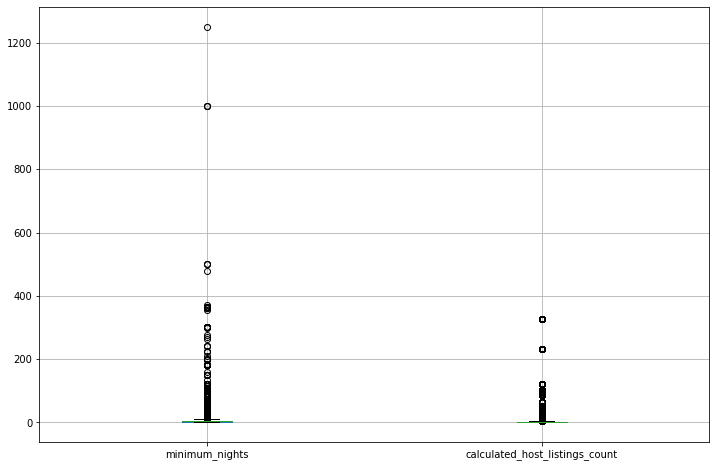

In [ ]:
df.boxplot(column=['minimum_nights', 'calculated_host_listings_count'], figsize=(12, 8))

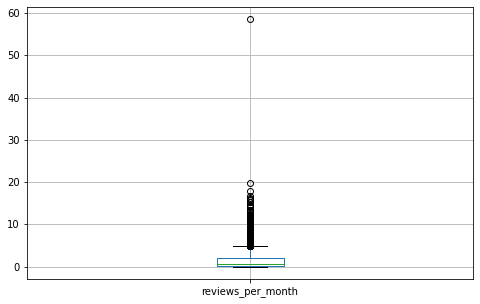

In [ ]:
df.boxplot(column='reviews_per_month', figsize=(8, 5))

We can decide to represent neighbourhood_group with integers

In [ ]:
df['neighbourhood_group'].unique()

array(['Queens', 'Manhattan', 'Brooklyn', 'Bronx', 'Staten Island'],
      dtype=object)

In [ ]:
df['room_type'].unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

In [ ]:
encoded_groups

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

# Let's make other kind of preprocessing:

In [ ]:
# preprocessing date for regression
import datetime as dt

df['last_review'] = pd.to_datetime(df['last_review']).map(dt.datetime.toordinal)

# Let's perform Regression Pipeline:

In [ ]:
models = [
  LinearRegression(),
  Ridge(random_state=42),
  MLPRegressor(hidden_layer_sizes=(10,), random_state=42, max_iter=10000),
  MLPRegressor(hidden_layer_sizes=(10,10), activation='tanh', solver='lbfgs',
    alpha=0.000, batch_size='auto', learning_rate='constant',
    learning_rate_init=0.01, power_t=0.5, max_iter=10000,
    shuffle=True, random_state=42, tol=0.0001, verbose=True, warm_start=False,
    momentum=0.0, nesterovs_momentum=False, early_stopping=False, 
    validation_fraction=0.0, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
  SVR(gamma='scale'),
  RandomForestRegressor(n_estimators=300), 
  make_pipeline(
  make_column_transformer(
    (FunctionTransformer(np.sin), [0]),
    (PolynomialFeatures(5), [0])
    ),

  LinearRegression()),
  make_pipeline(
  make_column_transformer(
    (FunctionTransformer(np.sin), [0]),
    (PolynomialFeatures(5), [0])
    ),
  Ridge(alpha=1)
  )
]



names = [
  'linreg',
  'ridge',
  'mlp_standard',
  'mlp_tuned',
  'svr',
  'rf',
  f'sin+poly{5}+linreg',
  f'sin+poly{5}+ridge'
]

Let's do regression without categorical attributes:

In [ ]:
df.columns

Index(['name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

In [ ]:
categorical_attr = ['name', 'host_id', 'host_name', 'neighbourhood_group',\
                    'neighbourhood', 'room_type']

In [ ]:
df_drop_cat_na = df.drop(columns=categorical_attr).dropna()

In [ ]:
t = PrettyTable()
t.field_names = ['model', 'MSE', 'R2']
for model, name in zip(models, names):
  X_train, X_test, y_train, y_test = train_test_split(df_drop_cat_na.drop(columns='price'), df_drop_cat_na['price'],
    train_size=.7,
    random_state=42,
    shuffle=True)
  model.fit(X_train, y_train)
  y_hat = model.predict(X_test)
  mse = mean_squared_error(y_test, y_hat)
  r2 = r2_score(y_test, y_hat)
  t.add_row([name, mse, r2])
print(t)

+------------------+--------------------+------------------------+
|      model       |        MSE         |           R2           |
+------------------+--------------------+------------------------+
|      linreg      | 26916.48245685793  |  0.048558176168394196  |
|      ridge       | 26917.403334259507 |  0.048525625062361355  |
|   mlp_standard   | 28380.705001139162 | -0.003199053635284832  |
|    mlp_tuned     | 28290.612138793593 | -1.445782483044944e-05 |
|       svr        | 29894.608788946036 | -0.056712412347190266  |
|        rf        | 26124.713710099277 |  0.07654555905456262   |
| sin+poly5+linreg | 27317.193172339743 |  0.034393883542938375  |
| sin+poly5+ridge  | 27675.81401279784  |  0.021717380695422284  |
+------------------+--------------------+------------------------+


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=7.71167e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Let's encode some categorical attribute and do regression:

In [ ]:
categorical_attr = ['name', 'host_id', 'host_name',\
                    'neighbourhood']

In [ ]:
df_drop_cat_na = df.dropna().drop(columns=categorical_attr)

In [ ]:
# This perform one-hot encoding
df_drop_cat_na = pd.get_dummies(df_drop_cat_na, columns=["neighbourhood_group", "room_type"], prefix=["group", "room"])

In [ ]:
t = PrettyTable()
t.field_names = ['model', 'MSE', 'R2']
for model, name in zip(models, names):
  X_train, X_test, y_train, y_test = train_test_split(df_drop_cat_na.drop(columns='price'), df_drop_cat_na['price'],
    train_size=.7,
    random_state=42,
    shuffle=True)
  model.fit(X_train, y_train)
  y_hat = model.predict(X_test)
  mse = mean_squared_error(y_test, y_hat)
  r2 = r2_score(y_test, y_hat)
  t.add_row([name, mse, r2])
print(t)

+------------------+--------------------+------------------------+
|      model       |        MSE         |           R2           |
+------------------+--------------------+------------------------+
|      linreg      | 34159.65069501224  |  0.10748406439513469   |
|      ridge       | 34157.20149454196  |  0.10754805657317934   |
|   mlp_standard   | 40550.38285332503  | -0.059491597692343134  |
|    mlp_tuned     |  38273.8091853129  | -9.775251578858501e-06 |
|       svr        | 39950.27046883575  |  -0.04381199162457028  |
|        rf        | 33968.856095557705 |  0.11246910425871226   |
| sin+poly5+linreg | 37530.522305799175 |  0.01941066293190874   |
| sin+poly5+ridge  | 37781.956454006395 |  0.012841246106374604  |
+------------------+--------------------+------------------------+


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=7.70258e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Let's try to normalize using Standard Scaler:

In [ ]:
interesting_models = [
  Ridge(random_state=42),
  RandomForestRegressor(n_estimators=300), 
]

interesting_names = [
  'ridge',
  'rf',
]

In [ ]:
from sklearn.preprocessing import StandardScaler

# create an abs_scaler object
scaler = StandardScaler()

# calculate the maximum absolute value for scaling the data using the fit method
scaler.fit(df_drop_cat_na.iloc[:, :9])

# transform the data using the parameters calculated by the fit method (the maximum absolute values)
scaled_data = scaler.transform(df_drop_cat_na.iloc[:, :9])

# store the results in a data frame
df_drop_cat_na.iloc[:, :9] = scaled_data

# visualize the data frame
df_drop_cat_na

,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,group_Bronx,group_Brooklyn,group_Manhattan,group_Queens,group_Staten Island,room_Entire home/apt,room_Private room,room_Shared room
id,,,,,,,,,,,,,,,,,
12783632,0.222208,1.402739,-0.343621,-0.271454,-0.565345,0.564030,-0.271228,-0.082781,1.822310,0,0,0,1,0,0,1,0
3463385,0.711583,-0.087631,-0.241990,-0.271454,3.580090,0.566424,1.148876,-0.120666,1.142815,0,0,1,0,0,0,1,0
33913644,-0.477526,0.815376,0.037496,-0.215924,-0.523891,0.664582,0.156586,-0.158551,-0.200733,0,1,0,0,0,1,0,0
9405895,-0.713266,-0.587364,0.926770,-0.160393,-0.275165,0.477843,-0.568321,-0.158551,-0.092632,0,1,0,0,0,1,0,0
7310413,-0.441370,0.828725,0.418614,-0.215924,-0.544618,-2.488426,-0.782228,-0.158551,-0.887951,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20678811,-1.455363,0.273442,-0.521476,-0.160393,0.595376,0.604730,0.709178,-0.082781,1.474841,0,1,0,0,0,0,1,0
29630190,-0.770238,-0.839276,-0.394436,-0.215924,-0.295892,0.547272,0.251655,-0.120666,-0.887951,0,1,0,0,0,0,1,0
3811639,-0.371799,0.624612,0.037496,-0.160393,3.600817,0.628671,1.214236,-0.158551,1.490284,0,1,0,0,0,1,0,0


In [ ]:
df_drop_cat_na.columns

In [ ]:
t = PrettyTable()
t.field_names = ['model', 'MSE', 'R2']
for model, name in zip(interesting_models, interesting_names):
  X_train, X_test, y_train, y_test = train_test_split(df_drop_cat_na.drop(columns='price'), df_drop_cat_na['price'],
    train_size=.7,
    random_state=42,
    shuffle=True)
  model.fit(X_train, y_train)
  y_hat = model.predict(X_test)
  mse = mean_squared_error(y_test, y_hat)
  r2 = r2_score(y_test, y_hat)
  t.add_row([name, mse, r2])
print(t)

+-------+--------------------+---------------------+
| model |        MSE         |          R2         |
+-------+--------------------+---------------------+
| ridge | 0.8820702349652658 | 0.10749395595585942 |
|   rf  | 0.8728993585180671 | 0.11677333341793783 |
+-------+--------------------+---------------------+


In [ ]:
df_drop_cat_na.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31056 entries, 12783632 to 15310580
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   latitude                        31056 non-null  float64
 1   longitude                       31056 non-null  float64
 2   price                           31056 non-null  float64
 3   minimum_nights                  31056 non-null  float64
 4   number_of_reviews               31056 non-null  float64
 5   last_review                     31056 non-null  float64
 6   reviews_per_month               31056 non-null  float64
 7   calculated_host_listings_count  31056 non-null  float64
 8   availability_365                31056 non-null  float64
 9   group_Bronx                     31056 non-null  uint8  
 10  group_Brooklyn                  31056 non-null  uint8  
 11  group_Manhattan                 31056 non-null  uint8  
 12  group_Queens          

Let's try a Grid Search:

In [ ]:
lasso_params = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03]}
ridge_params = {'alpha':[200, 230, 250,265, 270, 275, 290, 300, 500]}

models2 = {'OLS': LinearRegression(),
           'Ridge': GridSearchCV(Ridge(random_state=42), 
                               param_grid=ridge_params).fit(df_drop_cat_na.drop(columns='price'), df_drop_cat_na['price']).best_estimator_}

In [ ]:
models2['Ridge']

Ridge(alpha=200, random_state=42)

In [ ]:
t = PrettyTable()
t.field_names = ['model', 'MSE', 'R2']
for model, name in zip(models2.val, names):
  X_train, X_test, y_train, y_test = train_test_split(df_drop_cat_na.drop(columns='price'), df_drop_cat_na['price'],
    train_size=.7,
    random_state=42,
    shuffle=True)
  model.fit(X_train, y_train)
  y_hat = model.predict(X_test)
  mse = mean_squared_error(y_test, y_hat)
  r2 = r2_score(y_test, y_hat)
  t.add_row([name, mse, r2])
print(t)